<a href="https://colab.research.google.com/github/johnkevinoregan/Learning-Relations-with-Deep-Learning/blob/main/Bright_dark_compar_w_shuffle_DONT_CHANGE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bright vs dark comparison with generalization to different brightnesses and different retinal positions.

With option to shuffle the brightness metric.


18 Mar 2023

The purpose is to show that a NN cant learn to compare two brightnesses. You teach it to say "0" when the left of two pixels is brighter than the right and 1 otherwise. You train using the list X_train on just two retinal positions and one pair of brightnesses. In the training, both brightnesses trained occur at each retinal locations, so the NN cant use brightness to make its judgement, and must really rely on the comparison.

You then test it on a test list X_test, where the retinal positions are varied comparedd to the training set, and where the brightnesses are also varied.

If you set the option WhetherToShuffle=1, then all brightnesses between 0 and 255 will be permuted randomly, thereby destroying the natural intensity metric. We expect this to destroy the ability of the NN to generalize from the training brightnesses to nearby brightnesses.  

Results:
Not as clear as I had hoped. The NN gets the decision right at the trained brightness and location. At the trained location, using nearby brightnesses there does seem to be a gradual degradation in performance, as expected. I think, but am not sure, that this goes away on shuffling the brightness metric. 

But for a given brightness, there ALSO seems to be a gradual degradation when you gradually change the retinal location tested. I should recheck whether this is really the case however... the graphs are a bit difficult to read. If it's true, this was not expected, since I assumed that the NN had no natural metric for retinal position. I should check whether in keras, the "normal" non-Conv net is really fully connected, or whether there is only local connectivity: this might explain the effect.

(NB by switching what's commented in the plotting routine, you can plot the results as a function of brightness instead of as a function of retinal position.) 

(NB I'm not sure this whole thing is really working. Sometimes the testing doesnt give correct responses at the trained locations even though the error during training is zero.)



##Make training sets X_train and labels y_train

In [84]:
#initialize shuffler in case you want to destroy the natural brightness metric

def encode(array,shuff):
  [T,R]=np.shape(array)
  for t in range(T):
    for r in range(R):
      array[t]=shuff[array[t]]
  return(array)
import numpy as np

l=np.arange(255)

#these two arrays allow the brightness scale to be randomly permuted.
shuffler = np.random.permutation(len(l)) # returns indices to shuffle the list
undo_shuffler = np.argsort(shuffler) # returns indices to undo the shuffle

#to shuffle you do
#encode(array,shuffler)
#and to go back to original you do
#encode(array,undo_shuffler)



In [ ]:
#prepare test and training sets

import numpy as np

#IMPORTANT !!
WhetherToShuffle=0
#IMPORTANT THE VALUE ABOVE DETERMINES WHETHER TO SHUFFLE THE BRIGHTNESS LEVELS RANDOMLY


RetSize=18
Left=int(RetSize/4)
Right=3*Left
TrainRepeats=3
Deltas=3 #number of deviations from base retinal positions used in test

W=2 #half the number of brightnesses in the test set
W2=2*W

Brightnesses=np.arange(-W2,W2)*16+125-8
#print(Brightnesses)
LBrightnesses=len(Brightnesses)
#print('length',L)
X_test=np.zeros((LBrightnesses*(1+Deltas),RetSize),int)
y_test=np.zeros(LBrightnesses*(1+Deltas),int)
res_test=np.zeros(LBrightnesses*(1+Deltas),float)

X_train=np.zeros((2*TrainRepeats,RetSize),int)
y_train=np.zeros(2*TrainRepeats,int)
#print(X_train)

#used in plot routine:
LeftRetPosns=np.arange(Left-Deltas,Left+1)

trial=0
for DeltaPos in range(Deltas+1):
  for trial in range(LBrightnesses):
    T=trial+DeltaPos*LBrightnesses
    #print(T,Left-DeltaPos)
    X_test[T,Left-DeltaPos]=Brightnesses[trial]
    k=LBrightnesses-trial-1
    X_test[T,Right+DeltaPos]=Brightnesses[k]
    if X_test[T,Left-DeltaPos]<X_test[T,Right+DeltaPos]:
      y_test[T]=1
print('test stimuli')
print(X_test)
print('test labels')
print(y_test)

trial=0
while trial <= TrainRepeats+1:
  X_train[trial,Left]=Brightnesses[W]
  X_train[trial,Right]=Brightnesses[LBrightnesses-W-1]
  if X_train[trial,Left]<X_train[trial,Right]:
    y_train[trial]=1
  trial += 1
  X_train[trial,Left]=Brightnesses[LBrightnesses-W-1]
  X_train[trial,Right]=Brightnesses[W]
  if X_train[trial,Left]<X_train[trial,Right]:
    y_train[trial]=1
  trial +=1

print('training stimuli')
print(X_train)
print('training labels')
print(y_train)

if WhetherToShuffle==1:
  #only use this if you want to shuffle the brightness values
  encode(X_train,shuffler)
  print(X_train)
  encode(X_test,shuffler)
  print(X_test)

## Train with normal NN

In [ ]:
# Build, compile and train the neural network model
#there are two hidden layers with 64 and 32 values
#The ReLU activation function is used in deep learning models to introduce non-linearity into the network
#the sigmoid activation function produces a probability value between 0 and 1
from tensorflow import keras
import numpy as np
#from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
#from sklearn.model_selection import train_test_split
#from tensorflow.keras.callbacks import EarlyStopping


model = keras.models.Sequential([
    keras.layers.Dense(64, activation="relu", input_dim=len(X_train[0])),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

#model.fit(X_train, y_train, epochs=80, batch_size=32, validation_data=(X_test, y_test))
model.fit(X_train, y_train, epochs=80, batch_size=32)




# Test the model on the test data


In [90]:

for trial in range(len(X_test)):
  pred=model.predict(np.array([X_test[trial]]), verbose=0)
  res_test[trial]=pred[0][0]
  #print(np.around(pred[0][0],1),y_test[trial],X_test[trial])
  print(np.around(res_test[trial],2),y_test[trial],X_test[trial])

print(res_test)


1.0 1 [  0   0   0   0  53   0   0   0   0   0   0   0 165   0   0   0   0   0]
1.0 1 [  0   0   0   0  69   0   0   0   0   0   0   0 149   0   0   0   0   0]
1.0 1 [  0   0   0   0  85   0   0   0   0   0   0   0 133   0   0   0   0   0]
0.96 1 [  0   0   0   0 101   0   0   0   0   0   0   0 117   0   0   0   0   0]
0.1 0 [  0   0   0   0 117   0   0   0   0   0   0   0 101   0   0   0   0   0]
0.0 0 [  0   0   0   0 133   0   0   0   0   0   0   0  85   0   0   0   0   0]
0.0 0 [  0   0   0   0 149   0   0   0   0   0   0   0  69   0   0   0   0   0]
0.0 0 [  0   0   0   0 165   0   0   0   0   0   0   0  53   0   0   0   0   0]
0.0 1 [  0   0   0  53   0   0   0   0   0   0   0   0   0 165   0   0   0   0]
0.0 1 [  0   0   0  69   0   0   0   0   0   0   0   0   0 149   0   0   0   0]
0.0 1 [  0   0   0  85   0   0   0   0   0   0   0   0   0 133   0   0   0   0]
0.0 1 [  0   0   0 101   0   0   0   0   0   0   0   0   0 117   0   0   0   0]
0.0 0 [  0   0   0 117   0   0   0   0 

[[  0   0   0   0 117   0   0   0   0   0   0   0 101   0   0   0   0   0]
 [  0   0   0   0 133   0   0   0   0   0   0   0  85   0   0   0   0   0]
 [  0   0   0   0 149   0   0   0   0   0   0   0  69   0   0   0   0   0]
 [  0   0   0   0 165   0   0   0   0   0   0   0  53   0   0   0   0   0]
 [  0   0   0 117   0   0   0   0   0   0   0   0   0 101   0   0   0   0]
 [  0   0   0 133   0   0   0   0   0   0   0   0   0  85   0   0   0   0]
 [  0   0   0 149   0   0   0   0   0   0   0   0   0  69   0   0   0   0]
 [  0   0   0 165   0   0   0   0   0   0   0   0   0  53   0   0   0   0]
 [  0   0 117   0   0   0   0   0   0   0   0   0   0   0 101   0   0   0]
 [  0   0 133   0   0   0   0   0   0   0   0   0   0   0  85   0   0   0]
 [  0   0 149   0   0   0   0   0   0   0   0   0   0   0  69   0   0   0]
 [  0   0 165   0   0   0   0   0   0   0   0   0   0   0  53   0   0   0]
 [  0 117   0   0   0   0   0   0   0   0   0   0   0   0   0 101   0   0]
 [  0 133   0   0   0   0

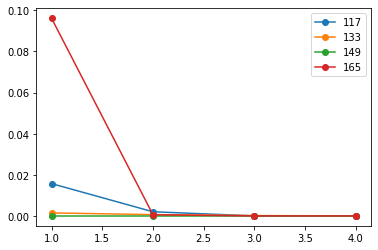

[[  0   0   0   0  53   0   0   0   0   0   0   0 165   0   0   0   0   0]
 [  0   0   0   0  69   0   0   0   0   0   0   0 149   0   0   0   0   0]
 [  0   0   0   0  85   0   0   0   0   0   0   0 133   0   0   0   0   0]
 [  0   0   0   0 101   0   0   0   0   0   0   0 117   0   0   0   0   0]
 [  0   0   0  53   0   0   0   0   0   0   0   0   0 165   0   0   0   0]
 [  0   0   0  69   0   0   0   0   0   0   0   0   0 149   0   0   0   0]
 [  0   0   0  85   0   0   0   0   0   0   0   0   0 133   0   0   0   0]
 [  0   0   0 101   0   0   0   0   0   0   0   0   0 117   0   0   0   0]
 [  0   0  53   0   0   0   0   0   0   0   0   0   0   0 165   0   0   0]
 [  0   0  69   0   0   0   0   0   0   0   0   0   0   0 149   0   0   0]
 [  0   0  85   0   0   0   0   0   0   0   0   0   0   0 133   0   0   0]
 [  0   0 101   0   0   0   0   0   0   0   0   0   0   0 117   0   0   0]
 [  0  53   0   0   0   0   0   0   0   0   0   0   0   0   0 165   0   0]
 [  0  69   0   0   0   0

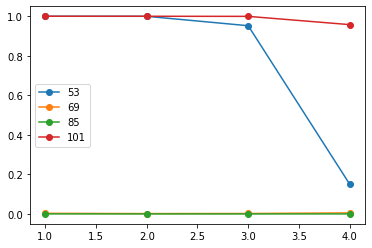

In [91]:
#Plot predictions in case response=0 as a fn of Brightnesses
#different lines are different retinal positions.

if WhetherToShuffle==1:
  encode(X_test,undo_shuffler)
  encode(X_train,undo_shuffler)


import matplotlib.pyplot as plt
for lab in range(2):
  Xlab=np.array(X_test[np.where(y_test==lab)])
  res_testlab=np.array(res_test[np.where(y_test==lab)])
  print(Xlab)
  
  for retpos in LeftRetPosns:
    #get column of trials in Xlab corresponding to retpos
    temp=Xlab[:,retpos]
    #extract the nonzero ones
    inds=np.nonzero(temp)
    print(inds)
    #get the brightnesses at those indices and use as x-coords
    xs=np.array(temp[inds])
    #and the predictions for those brightnesses as y-coords
    ys=res_testlab[inds]
    print(xs)
    print(ys)
    #plt.plot([1,2,3,4],ys,label=xs[retpos-1],marker="o")
    plt.plot(LeftRetPosns,ys,label=xs[retpos-1],marker="o")
    #plt.plot(xs,ys,label=retpos,marker="o")
  print('response',lab, 'trained on brightnesses', X_train[lab,(4,12)], 'at location 4')
  plt.legend(loc="best")
  plt.show()



Comment on results:


## Train with CNN

In [ ]:


if WhetherToShuffle==1:
  #only use this if you want to shuffle the brightness values
  encode(X_train,shuffler)
  print(X_train)
  encode(X_test,shuffler)
  print(X_test)

model = Sequential()
model.add(Conv1D(filters=32, kernel_size=4, activation='relu', input_shape=(len(X_train[0]), 1)))
model.add(MaxPooling1D(pool_size=4))
#model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=40, batch_size=32, verbose=1)

#loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
#print("Accuracy:", accuracy)

Epoch 1/40
1/1 [==============================] - 1s 858ms/step - loss: 3.8117 - accuracy: 0.5000
Epoch 2/40
1/1 [==============================] - 0s 10ms/step - loss: 0.8611 - accuracy: 0.5000
Epoch 3/40
1/1 [==============================] - 0s 11ms/step - loss: 0.0311 - accuracy: 1.0000
Epoch 4/40
1/1 [==============================] - 0s 10ms/step - loss: 0.3575 - accuracy: 0.5000
Epoch 5/40
1/1 [==============================] - 0s 9ms/step - loss: 0.8174 - accuracy: 0.5000
Epoch 6/40
1/1 [==============================] - 0s 9ms/step - loss: 0.7302 - accuracy: 0.5000
Epoch 7/40
1/1 [==============================] - 0s 10ms/step - loss: 0.3543 - accuracy: 0.5000
Epoch 8/40
1/1 [==============================] - 0s 10ms/step - loss: 0.0943 - accuracy: 1.0000
Epoch 9/40
1/1 [==============================] - 0s 9ms/step - loss: 0.0203 - accuracy: 1.0000
Epoch 10/40
1/1 [==============================] - 0s 10ms/step - loss: 0.0051 - accuracy: 1.0000
Epoch 11/40
1/1 [==============

###Test CNN 


In [ ]:

for trial in range(len(X_test)):
  pred=model.predict(np.array([X_test[trial]]), verbose=0)
  res_test[trial]=pred[0][0]
  #print(np.around(pred[0][0],1),y_test[trial],X_test[trial])
  print(np.around(res_test[trial],1),y_test[trial],X_test[trial])

print(res_test)


1.0 1 [  0   0   0   0  53   0   0   0   0   0   0   0 165   0   0   0   0   0]
1.0 1 [  0   0   0   0  69   0   0   0   0   0   0   0 149   0   0   0   0   0]
1.0 1 [  0   0   0   0  85   0   0   0   0   0   0   0 133   0   0   0   0   0]
0.8 1 [  0   0   0   0 101   0   0   0   0   0   0   0 117   0   0   0   0   0]
0.0 0 [  0   0   0   0 117   0   0   0   0   0   0   0 101   0   0   0   0   0]
0.0 0 [  0   0   0   0 133   0   0   0   0   0   0   0  85   0   0   0   0   0]
0.0 0 [  0   0   0   0 149   0   0   0   0   0   0   0  69   0   0   0   0   0]
0.0 0 [  0   0   0   0 165   0   0   0   0   0   0   0  53   0   0   0   0   0]
1.0 1 [  0   0   0  53   0   0   0   0   0   0   0   0   0 165   0   0   0   0]
1.0 1 [  0   0   0  69   0   0   0   0   0   0   0   0   0 149   0   0   0   0]
1.0 1 [  0   0   0  85   0   0   0   0   0   0   0   0   0 133   0   0   0   0]
0.9 1 [  0   0   0 101   0   0   0   0   0   0   0   0   0 117   0   0   0   0]
0.4 0 [  0   0   0 117   0   0   0   0  

In [ ]:
#Plot predictions in case response=0 as a fn of Brightnesses
#different lines are different retinal positions.

if WhetherToShuffle==1:
  encode(X_test,undo_shuffler)
  encode(X_train,undo_shuffler)


import matplotlib.pyplot as plt
for lab in range(2):
  Xlab=np.array(X_test[np.where(y_test==lab)])
  res_testlab=np.array(res_test[np.where(y_test==lab)])
  print(Xlab)
  
  for retpos in LeftRetPosns:
    #get column of trials in Xlab corresponding to retpos
    temp=Xlab[:,retpos]
    #extract the nonzero ones
    inds=np.nonzero(temp)
    print(inds)
    #get the brightnesses at those indices and use as x-coords
    xs=np.array(temp[inds])
    #and the predictions for those brightnesses as y-coords
    ys=res_testlab[inds]
    print(xs)
    print(ys)
    plt.plot(LeftRetPosns,ys,label=xs[retpos-1],marker="o")
    #plt.plot(xs,ys,label=retpos,marker="o")
  print('response',lab, 'trained on brightnesses', X_train[lab,(4,12)], 'at location 4')
  plt.legend(loc="best")
  plt.show()



Comment on results:


# EXTRA OLD STUFF BELOW

[ 21  37  53  69  85 101 117 133 149 165 181 197 213  21  37  53  69  85
 101 117 133 149 165 181 197 213  21  37  53  69  85 101 117 133 149 165
 181 197 213  21  37  53  69  85 101 117 133 149 165 181 197 213]
[1.   1.   1.   1.   1.   1.   1.   0.44 0.   0.   0.   0.   0.   1.
 1.   1.   1.   1.   1.   1.   0.97 0.55 0.04 0.   0.   0.   1.   1.
 1.   1.   1.   1.   1.   1.   0.98 0.86 0.58 0.27 0.12 0.41 0.33 0.27
 0.21 0.16 0.12 0.09 0.07 0.05 0.04 0.03 0.02 0.02]


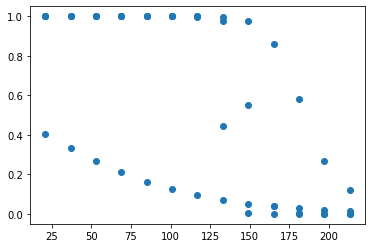

In [ ]:
#Plot the prediction for each Brightness level
#NB I should really separate them depending on whether the correct answer is 0 or 1, but I havent done it.
#Also I should separate out according to retinal position..
import matplotlib.pyplot as plt
x_vals=np.zeros(len(X_test),int)
for trial in range(len(X_test)):
  x=np.where(X_test[trial]>0)[0][0]
  x_vals[trial]=X_test[trial][x]
print(x_vals)
print(np.around(res_test,2))
plt.scatter(x_vals,res_test)

In [ ]:
#plotting brightnesses on x-axis and color as retinal pos
import matplotlib.pyplot as plt
#make new X_test array with just cases where label==lab
#print('locs',np.where(y_test==lab))
for lab in range(2):
  X_0=np.array(X_test[np.where(y_test==lab)])
  #print(X_0)
  res_test0=res_test[np.where(y_test==lab)]
  #print(res_test0)
  xs=np.zeros(len(X_0), int)
  ys=np.zeros(len(X_0), float)
  cols=xs.copy()

  for trial in range(len(X_0)):
    Pos=(np.where(X_0[trial]>0))[0][0]
    xs[trial]=X_0[trial,Pos]
    ys[trial]=res_test0[trial]
    #print(trial, Pos)
    cols[trial]=Pos
    #cols[trial]=np.where(Brightnesses==X_0[trial,Pos])[0]
    #print(xs[trial],ys[trial],cols[trial])
  print(xs)
  print(np.around(ys,2))
  print(cols)


  plt.scatter(xs,ys,c=cols)
  plt.show()

[4 4 4 4 3 3 3 3 2 2 2 2 1 1 1 1] [1.35788438e-03 1.58618808e-01 2.81287008e-04 9.00020957e-01
 1.00000000e+00 9.99997735e-01 1.99722573e-02 1.00000000e+00
 3.71716852e-10 1.05307457e-07 1.20874483e-03 1.72568058e-12
 2.03454911e-04 3.94408475e-04 1.19937537e-02 6.46831188e-03] [117 133 149 165 117 133 149 165 117 133 149 165 117 133 149 165]


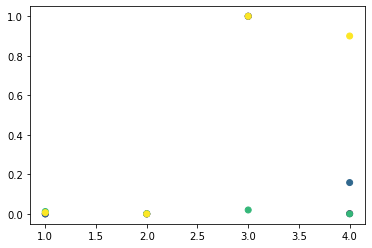

[4 4 4 4 3 3 3 3 2 2 2 2 1 1 1 1] [1.12211652e-01 8.76822472e-02 8.58184636e-01 9.99304473e-01
 1.00000000e+00 3.44770178e-02 9.99989450e-01 9.99981403e-01
 4.94652496e-13 3.92273813e-03 3.87841908e-07 1.55491918e-07
 5.43226581e-03 7.11521483e-04 2.70219112e-04 3.63955070e-04] [ 53  69  85 101  53  69  85 101  53  69  85 101  53  69  85 101]


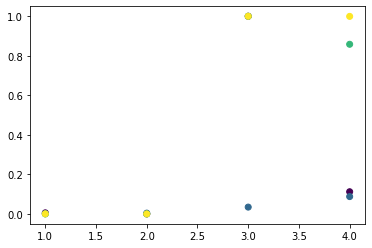

In [ ]:

if WhetherToShuffle==1:
  #unshuffle now if you previously shuffled
  encode(X_test,undo_shuffler)
  print(X_test)

#plotting retinal pos as x-axis and brightness as color
import matplotlib.pyplot as plt
#make new X_test array with just cases where label==lab
#print('locs',np.where(y_test==lab))
for lab in range(2):
  X_0=np.array(X_test[np.where(y_test==lab)])
  #print(X_0)
  res_test0=res_test[np.where(y_test==lab)]
  #print(res_test0)
  xs=np.zeros(len(X_0), int)
  ys=np.zeros(len(X_0), float)
  cols=xs.copy()

  for trial in range(len(X_0)):
    Pos=(np.where(X_0[trial]>0))[0][0]
    xs[trial]=Pos
    ys[trial]=res_test0[trial]
    #print(trial, Pos)
    cols[trial]=X_0[trial,Pos]
    #cols[trial]=np.where(Brightnesses==X_0[trial,Pos])[0]
    #print(xs[trial],ys[trial],cols[trial])
  print(xs,ys,cols)


  plt.scatter(xs,ys,c=cols)
  plt.show()